# Análise e considerações iniciais do dataset

Nessa etapa, os dados são carregados e uma série de observações é feita sobre eles, incluindo se possui valores nulos e outliers.

Dicionários dos atributos:
- Indivíduo: Pessoal que executou a atividade.
- Atividade: Atividades do dia a dia realizada por humanos.
- Timestamp: Device uptime em nanosegundos.
- Aceleração no eixo X: Valor da aceleração no eixo X, sendo 10 = 1g = 9.81 m/s^2 e 0 sem aceleração.
- Aceleração no eixo Y: Mesmo que X para eixo Y.
- Aceleração no eixo Z: Mesmo que X para eixo Z.

In [1]:
import pandas

dataset_file_path = "./dataset/coleta.txt"

columns = ["individuo", "atividade", "timestamp", "x", "y", "z"]

df = pandas.read_csv(
    dataset_file_path,
    sep=",",
    names=columns,
    lineterminator=';'
)

df.head()

/home/alps2/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,individuo,atividade,timestamp,x,y,z
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164


In [2]:
df.dtypes

individuo     object
atividade     object
timestamp    float64
x            float64
y            float64
z            float64
dtype: object

- "individuo" foi marcado como object, mas poderia muito bem ser um int (mesmo que nenhuma operação aritmética seja feita em cima desse valor). Representa apenas de qual indivíduo foi feita a coleta. Possivelmente será pouco útil para o modelo.
- "atividade" foi marcado como object e representa a classe ou "label" do problema.
- "timestamp" poderia ser um int, mas não faz mal deixá-lo como float. Possivelmente não vai ser útil para o modelo, mas será útil para a criação do dataset com janela de tempo de 3 segundos e overlap de 75%, como foi requerido.
- "x", "y" e "z" foram corretamente tipados como float.

In [3]:
df.describe()

,timestamp,x,y,z
count,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06
mean,3.340895e+13,6.628650e-01,7.255622e+00,4.110796e-01
std,4.944962e+13,6.849046e+00,6.746217e+00,4.754122e+00
min,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,2.019110e+12,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,9.722677e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,4.996560e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


Tipos de atividades e médias dos atributos numéricos para cada uma

In [4]:
df.groupby("atividade")["x", "y", "z"].mean()

/tmp/ipykernel_84826/3886283452.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("atividade")["x", "y", "z"].mean()


,x,y,z
atividade,,,
Downstairs,0.471718,8.600230,0.684080
Jogging,-0.201963,5.461080,-0.124295
Sitting,1.856270,1.853374,6.559716
Standing,-1.178258,8.987236,0.580193
Upstairs,0.381334,8.111545,0.323542
Walking,1.528285,8.702038,-0.084196


Existem pouquíssimos registros com valores nulos. Por causa disso, foi decidido removê-los.

In [5]:
df.isna().sum()

individuo    0
atividade    1
timestamp    1
x            1
y            1
z            1
dtype: int64

Valores com zero

Ao analisar empiricamente o dataset, foram percebidos diversos registros com todos os campos numéricos zerados.

Inicialmente, admitiu-se a possibilidade de serem registros que indicavam atividade estacionária.

Porém, após analisar os tipos de classes presentes e as médias de valores para eles, foi concluído que esses registros zerados representavam ruído e são uma pequena parcela do dataset.

Por conta dessas observações, foi decidido remover os registros com esse perfil.

In [6]:
print("total_records:", len(df))
print("zeroed_records:", len(df.loc[(df["timestamp"] == 0) & (df["x"] == 0) & (df["y"] == 0) & (df["z"] == 0)])) 

total_records: 1098209
zeroed_records: 12841


Histograma e boxplot

Após analisar os seguintes gráficos, não podemos concluir a existência de outliers, porém vemos uma distribuição normal razoavelmente boa.

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

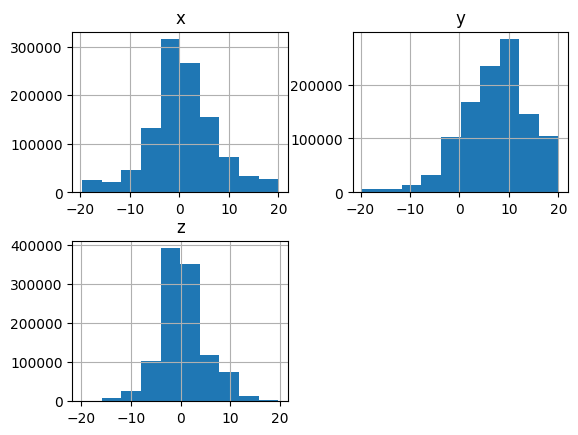

In [7]:
df[["x", "y", "z"]].hist()

<AxesSubplot:>

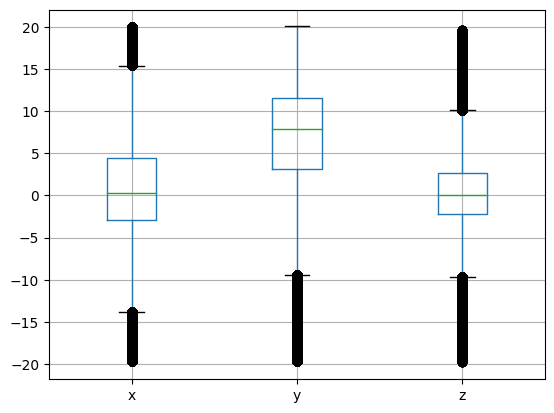

In [8]:
df[["x", "y", "z"]].boxplot()

# Transformações e tratamento dos dados

Baseando-se nas conclusões da seção anterior e requisitos do problema, as seguintes transformações ou tratamentos serão efetuados:
1. Remoção de valores nulos;
2. Remoção de registros onde todos os dados numéricos são zerados;
3. Transformação do dataset utilizando a técnica de data augmentation "janela deslizante", em relação ao timestamp. O tamanho da janela é um intervalo de 3 segundos e deve existir um overlap de 75% nos dados.

In [9]:
df = df.dropna()
df.isna().sum()

individuo    0
atividade    0
timestamp    0
x            0
y            0
z            0
dtype: int64

In [10]:
df = df.loc[(df["timestamp"] != 0) & (df["x"] != 0) & (df["y"] != 0) & (df["z"] != 0)]
len(df)

1075789

# importando meu módulo dataprep

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('./dataprep'))
sys.path.insert(0, module_path)

In [12]:
from dataprep import create_time_window_data

time_interval = 3
overlap = 0.75
df = create_time_window_data(df, time_interval, overlap)

df.head()

,individuo,atividade,timestamp,x,y,z
456682,35,Standing,7.345234e+10,2.03,9.47,2.91
456683,35,Standing,7.350233e+10,2.15,9.30,2.83
456684,35,Standing,7.355235e+10,2.22,9.38,2.83
456685,35,Standing,7.360234e+10,2.37,9.34,3.02
456686,35,Standing,7.365232e+10,2.30,9.28,2.83


In [13]:
print("total records after data augmentation:", len(df))

total records after data augmentation: 4302938
